<h1>Neural Collaborative Filtering</h1>

In [14]:
import sys
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k,  
                                                     recall_at_k, get_top_k_items)

import matplotlib.pyplot as plt

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas version: 1.5.3
Tensorflow version: 2.11.0


In [15]:
#tf.config.threading.set_inter_op_parallelism_threads(6)

In [16]:
from tqdm import tqdm
import numpy as np

In [17]:
# top k items to recommend
TOP_K = 100

<h1>Load the dataset</h1>

In [44]:
dataset_name = 'sas'

In [60]:
train_file = "../data/{}/train.csv".format(dataset_name)
test_file = "../data/{}/test.csv".format(dataset_name)

train = pd.read_csv(train_file)
test  = pd.read_csv(test_file)

<AxesSubplot: >

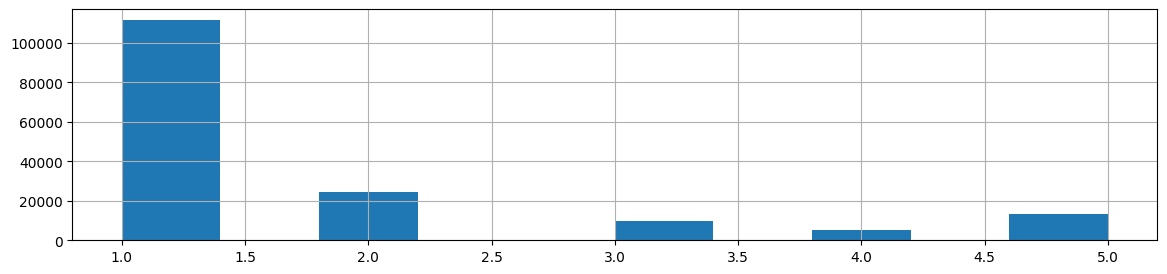

In [61]:
plt.figure(figsize=(14, 3))
train['rating'].hist()

In [47]:
train['rating'] = np.max(train['rating'].values, 0)
test['rating'] = np.max(test['rating'].values, 0)

train['rating'] /=5
test['rating'] /=5

train_file = '../data/{}/train_tmp.csv'.format(dataset_name)
test_file = '../data/{}/test_tmp.csv'.format(dataset_name)

train.to_csv(train_file)
test.to_csv(test_file)

In [22]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=42, binary=False)

INFO:recommenders.models.ncf.dataset:Indexing ../data/sas/train_tmp.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ../data/sas/test_tmp.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ../data/sas/test_tmp_full.csv ...


<h1>Train the NCF model on the training data, and get the top-k recommendations for our testing data</h1>

- NCF accepts implicit feedback and generates prospensity of items to be recommended to users in the scale of 0 to 1
- A recommended item list can then be generated based on the scores

In [23]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=16,
    layer_sizes=[16,8,4],
    n_epochs=2,
    batch_size=256,
    learning_rate=1e-3,
    verbose=1,
    seed=42
)

2023-05-08 08:50:49.566002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-05-08 08:50:49.569696: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [24]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

100%|██████████| 47759/47759 [00:34<00:00, 1399.29it/s]
3213it [00:34, 94.10it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [34.16s]: train_loss = 0.454617 
100%|██████████| 47759/47759 [00:34<00:00, 1390.79it/s]
3213it [00:34, 93.53it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [34.35s]: train_loss = 0.375897 


Took 68.5178 seconds for training.


In [25]:
def get_top_n_recommendations(model, user_id, n=100):
    item_ids = np.arange(model.n_items)
    user_ids = np.full(model.n_items, user_id, dtype=np.int32)
    
    scores = np.array(model.predict(user_ids, item_ids, is_list=True))
    top_n_indices = np.argsort(scores)[-n:]  # Get the indices of the top N items
    
    return item_ids[top_n_indices], scores[top_n_indices]

In [26]:
with Timer() as inference_time:
    users, items, preds = [], [], []

    for user in tqdm(train.userID.unique()):
        item, score = get_top_n_recommendations(model, user, 200)
        user = [user] * len(item)

        users.extend(user)
        items.extend(item)
        preds.extend(score)

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})
    # exlcude predicted
    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(inference_time))

100%|██████████| 47759/47759 [01:56<00:00, 409.12it/s]


Took 139.7641 seconds for prediction.


<h1>Evaluate how well NCF performs</h1>

In [65]:
# top k items to recommend
TOP_K = 10

eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("K:\t%f" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

K:	10.000000
MAP:	0.025399
NDCG:	0.040805
Precision@K:	0.013733
Recall@K:	0.066722


In [66]:
from copy import deepcopy

predictions = []
for z, (u, i, r, t) in tqdm(test.iterrows(), total=test.shape[0]):
    prediction = model.predict(int(u), int(i))
    predictions.append(prediction)

pred = deepcopy(test)
pred = pred.drop('rating', axis=1)
pred['prediction'] = predictions

100%|██████████| 44568/44568 [00:11<00:00, 3777.80it/s]


In [29]:
def rating_metrics(data_true, data_pred):
    
    eval_rmse = rmse(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
    eval_mae = mae(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
    eval_exp_var = exp_var(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
    eval_rsquared = rsquared(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")


    print("Model:\ NCF rating prediction",
      "RMSE:\t%f" % eval_rmse,
      "MAE:\t%f" % eval_mae,
      "Explained variance:\t%f" % eval_exp_var,
      "R squared:\t%f" % eval_rsquared, sep='\n')

In [30]:
rating_metrics(
    data_true=test,
    data_pred=pred,
)

Model:\ NCF rating prediction
RMSE:	0.631926
MAE:	0.556109
Explained variance:	0.000000
R squared:	0.000000


In [121]:
#pred['prediction'] *= 5
#test['rating'] *= 5

In [122]:
#merged['rating'] = np.max(merged['rating'].values, 0)

<h3>SAS RFM</h3>

In [ ]:
from copy import deepcopy

In [67]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

In [69]:
merged_pred = deepcopy(all_predictions)
merged_test = deepcopy(test)

In [70]:
ndcg_at_k(merged_test, merged_pred, col_prediction='prediction', k=10)

0.04080524586475515

In [71]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(5806, 4) (557227, 4)
(3557, 4) (572160, 4)
(4122, 4) (840580, 4)
(4400, 4) (1158292, 4)
(2720, 4) (1012586, 4)
(574, 4) (383736, 4)


In [72]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.0385
Champions 0.0381
Loyal 0.0449
Potential 0.0369
Sleeping 0.0418
Require Activation 0.052


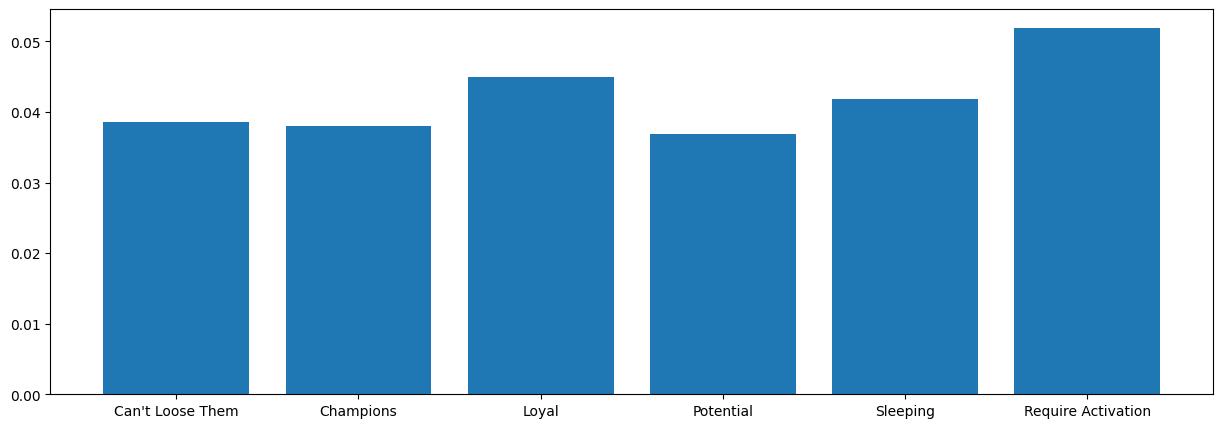

In [73]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);